In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import time

from classification.evaluation import performance_indices, roc_analysis
from classification.inputs import hparams
from classification.training import training_model, training_history
from glob import glob
from IPython.display import display, clear_output

np.set_printoptions(precision=4, suppress=True)

plt.style.use("seaborn-v0_8-paper")
plt.style.use("styles/l3_mod.mplstyle")

tf.random.set_seed(13)
np.random.seed(13)

In [2]:
data_folder = "003points"
data_path = os.path.join("data", "experimental", "regression", data_folder)

train_files = glob(os.path.join(data_path, "train_data*.csv"))
valid_files = glob(os.path.join(data_path, "valid_data*.csv"))

train_data = pd.read_csv(train_files[0])
valid_data = pd.read_csv(valid_files[0])

print(f"train: {train_data.shape}, valid: {valid_data.shape}")

train: (1111, 58), valid: (139, 58)


In [19]:
# training
results = []
for hp in hparams:
    r = training_model(train_files, valid_files, **hp)
    clear_output(wait=True)
    results.append(r)
    time.sleep(1)

  0%|          | 0/10 [00:00<?, ?it/s]

Model: Modelo #8
    Archtecture Params: {'hidden_layers': [128, 128, 128], 'activation': <function relu at 0x0000020A3A09C430>}
    Optimization Params: {'lr': 0.001, 'epochs': 500, 'batch_size': 32}

Epoch 1/500
35/35 [==============================] - 1s 13ms/step - loss: 0.8642 - categorical_accuracy: 0.7903 - val_loss: 0.5224 - val_categorical_accuracy: 0.8777 - lr: 0.0010
Epoch 2/500
35/35 [==============================] - 0s 2ms/step - loss: 0.3274 - categorical_accuracy: 0.8965 - val_loss: 0.3549 - val_categorical_accuracy: 0.8273 - lr: 0.0010
Epoch 3/500
35/35 [==============================] - 0s 3ms/step - loss: 0.2242 - categorical_accuracy: 0.9109 - val_loss: 0.2743 - val_categorical_accuracy: 0.8705 - lr: 0.0010
Epoch 4/500
35/35 [==============================] - 0s 2ms/step - loss: 0.2099 - categorical_accuracy: 0.9181 - val_loss: 0.2233 - val_categorical_accuracy: 0.9065 - lr: 0.0010
Epoch 5/500
35/35 [==============================] - 0s 2ms/step - loss: 0.1834 - cat

In [ ]:
training_history(results, model_id=0)

,model,hidden_layers,activation
0,Modelo #1,[],<function relu at 0x0000020A3A09C430>
1,Modelo #2,[32],<function relu at 0x0000020A3A09C430>
2,Modelo #3,[128],<function relu at 0x0000020A3A09C430>
3,Modelo #4,"[32, 32]",<function relu at 0x0000020A3A09C430>
4,Modelo #5,"[128, 128]",<function relu at 0x0000020A3A09C430>
5,Modelo #6,"[32, 32, 32]",<function swish at 0x0000020A3A09C280>
6,Modelo #7,"[32, 32, 32]",<function relu at 0x0000020A3A09C430>
7,Modelo #8,"[128, 128, 128]",<function relu at 0x0000020A3A09C430>


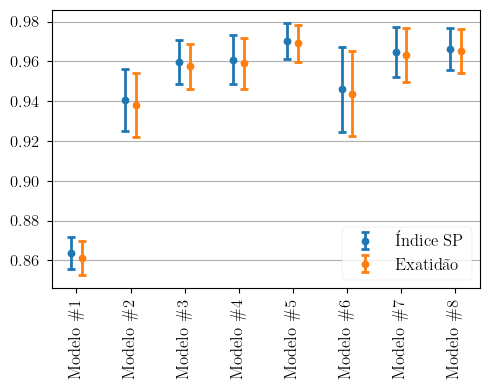

In [20]:
indices = performance_indices(results, valid_files)

accuracy = indices["accucary"]
sp_index = indices["sp_index"]

f, ax = plt.subplots(figsize=(5, 4))

labels = [hp["model_name"].replace("#", "\#") for hp in hparams]
x = np.array([i + 1 for i in np.arange(len(results))])
y = sp_index.mean(axis=0)
yerr = sp_index.std(axis=0)
ax.errorbar(
    x - 0.1,
    sp_index.mean(axis=0),
    sp_index.std(axis=0),
    fmt="o",
    elinewidth=2.0,
    capsize=3.0,
    capthick=2.0,
    label="Índice SP",
)
ax.errorbar(
    x + 0.1,
    accuracy.mean(axis=0),
    accuracy.std(axis=0),
    fmt="o",
    elinewidth=2.0,
    capsize=3.0,
    capthick=2.0,
    label="Exatidão",
)
ax.yaxis.grid()
# ax.set_ylabel("Índice Soma-Produto")
ax.set_xticks(x, labels, rotation=90, ha="center")
ax.legend()

arch_params = [hp["arch"] for hp in hparams]

df = pd.DataFrame.from_records(arch_params)
df["model"] = [hp["model_name"] for hp in hparams]
display(df[["model", "hidden_layers", "activation"]])
plt.show()

In [21]:
# training_history(results[0])

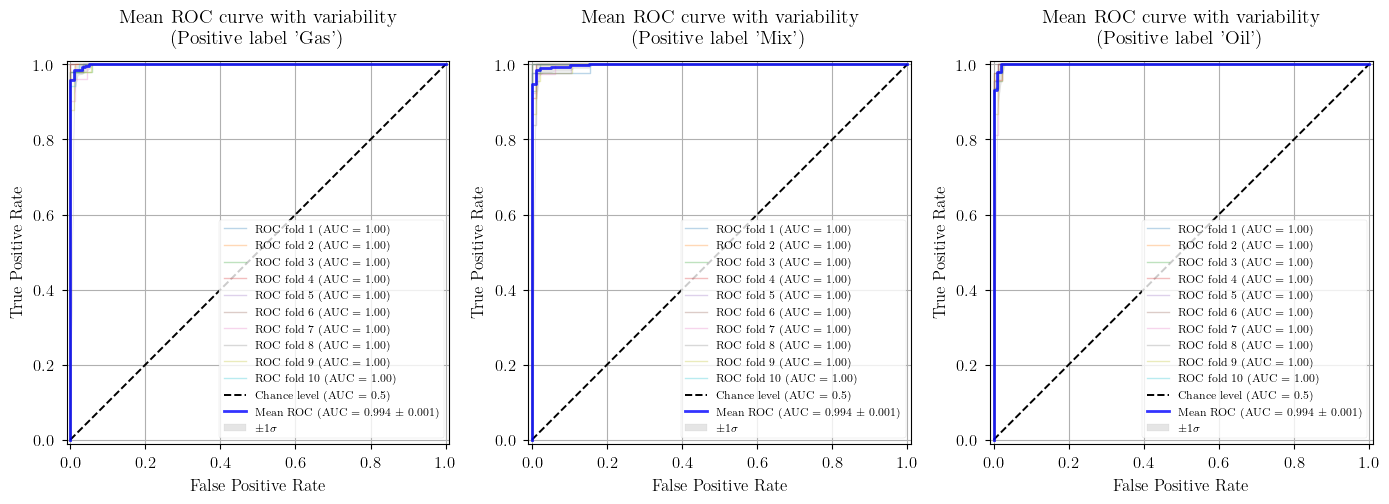

In [22]:
roc_analysis(
    results,
    valid_files,
    model_id=4,
    figsize=(14, 5),
    # xlim=(0., 0.2),
    # ylim=(0.8, 1.01),
)

In [34]:
# Phase Diagram
import tensorflow as tf

from classification.training import preprocessing
from datetime import datetime
from experimental_data.utils import set_components
from neqsim.thermo import TPflash

num_points = 500
model_ids = [0, 4]
fold_id = 0

# Data preparation
# P_sample (min, max): (10, 450)
# T_sample (min, max): (150, 1125)
pressure = np.linspace(10, 450, num=num_points)
temperature = np.linspace(150, 1125, num=num_points)

PP, TT = np.meshgrid(pressure, temperature)
P = PP.flatten().reshape(-1, 1)
T = TT.flatten().reshape(-1, 1)

data = valid_data.iloc[:1, :].copy()
data = pd.DataFrame(
    np.tile(data.values, (num_points * num_points, 1)),
    columns=data.columns,
)
data[["P", "T"]] = np.c_[P, T]

features, _ = preprocessing(data)
features = features.apply(lambda s: pd.to_numeric(s))

# Fluid preparation
composition = valid_data.iloc[0, valid_data.columns.str.startswith("z")].to_dict()
fluid = set_components(composition)

probs = []
models_labels = []
for model_id in model_ids:
    labels = []
    # Call simulation
    start = datetime.now()
    for d in data.to_dict(orient="records"):
        fluid.setPressure(d["P"], "bara")
        fluid.setTemperature(d["T"], "K")

        TPflash(fluid)

        phases = [p for p in fluid.getPhases() if p]
        label = ",".join([str(phase.getPhaseTypeName()) for phase in phases])

        if label == "oil,liquid":
            labels.append("oil")
        elif label == "gas,liquid":
            labels.append("gas")
        elif label == "gas,oil":
            labels.append("mix")

    labels = pd.get_dummies(pd.Series(labels)).astype(int).values
    models_labels.append(labels)
    print(f"Model ID: {model_id}, Sim Elapsed Time: {datetime.now() - start}", end=", ")

    # Call neural network model predictions
    start = datetime.now()
    model = results[model_id][fold_id]["model"]
    logits = model(features.values)
    probs.append(tf.nn.softmax(logits, axis=1).numpy())
    print(f"NN Elapsed Time: {datetime.now() - start}")

Model ID: 0, Sim Elapsed Time: 0:11:59.134500, NN Elapsed Time: 0:00:00.029021
Model ID: 4, Sim Elapsed Time: 0:12:00.537462, NN Elapsed Time: 0:00:00.168186


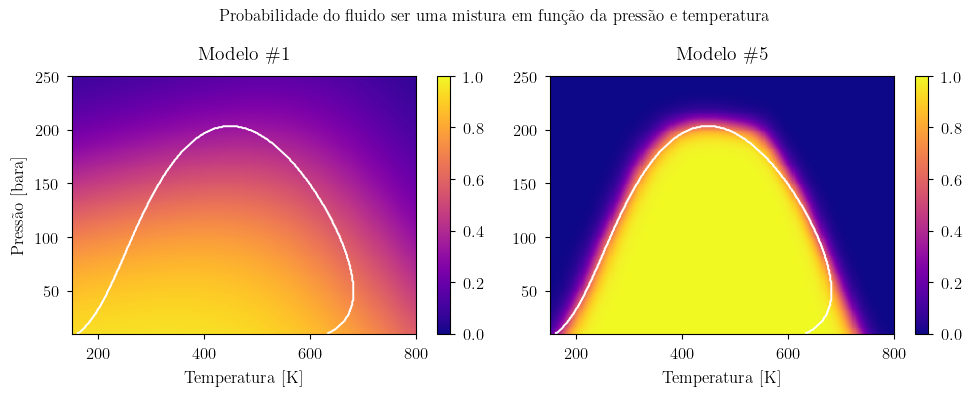

In [62]:
# plot
f, axs = plt.subplots(1, 2, figsize=(10, 4))

for i in range(len(model_ids)):
    label = 1
    model_id = model_ids[i]
    p = probs[i]
    l = models_labels[i]

    axs[i].contour(
        TT,
        PP,
        l[:, label].reshape(num_points, num_points),
        levels=0,
        colors="white",
    )

    pcm = axs[i].pcolormesh(
        TT,
        PP,
        p[:, label].reshape(num_points, num_points),
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )

    axs[i].set_xlabel("Temperatura [K]")
    axs[i].set_title(results[model_id][fold_id]["model_name"].replace("#", "\#"))
    axs[i].set_xlim((150, 800)) # Temperature
    axs[i].set_ylim((10, 250))  # Pressure
    cbar = f.colorbar(pcm, ax=axs[i])

axs[0].set_ylabel("Pressão [bara]")
f.suptitle("Probabilidade do fluido ser uma mistura em função da pressão e temperatura")
# f.tight_layout()
plt.show()